In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import os
from pathlib import Path

### Crop images

In [9]:
def split_video(video_name):
    save_dir = video_name[:-4]
    vidcap = cv2.VideoCapture(f"data/{video_name}")
    ret, image = vidcap.read()
    count = 1

    if (
        save_dir not in os.listdir("data_frames")
        or save_dir == "Toyota_rav4_2015_black_01"
    ):
        #         os.mkdir(f"data_frames/{save_dir}")

        while ret:
            cv2.imwrite(f"data_frames/{save_dir}/frame{count}.jpg", image)
            ret, image = vidcap.read()
            count += 1

<IPython.core.display.Javascript object>

In [10]:
video_ext = ["mov", "mp4"]
for f in tqdm(os.listdir("data")):
    if f[-3:].lower() in video_ext:
        split_video(f)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:46<00:00,  2.01it/s]


<IPython.core.display.Javascript object>

In [7]:
def crop_frames(save_dir, df):
    if save_dir not in os.listdir("data_crops"):
        os.mkdir(f"data_crops/{save_dir}")
    if len(df) != len(os.listdir(f"data_crops/{save_dir}")):
        for i, row in df.iterrows():
            k, id, x, y, w, h = row.values
            img = cv2.imread(f"data_frames/{save_dir}/frame{int(k)}.jpg")
            if img is None:
                print(save_dir)
            crop = img[int(y) : int(y + h), int(x) : int(x + w)]
            if crop.size != 0:
                cv2.imwrite(f"data_crops/{save_dir}/frame{int(k)}.jpg", crop)

<IPython.core.display.Javascript object>

In [11]:
for f in tqdm(os.listdir("data")):
    if ".txt" in f:
        df = pd.read_csv(
            f"data/{f}",
            sep="\t",
            header=None,
            names=["k", "ID_i", "x", "y", "width", "height"],
            skiprows=3,
        )
        crop_frames(f[:-4], df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [04:21<00:00,  2.78s/it]


<IPython.core.display.Javascript object>

## Extract features with use of HOG descriptor

In [2]:
from feature_descriptors import HogFeatureDescriptor

hog = HogFeatureDescriptor()

In [3]:
crops = {}

In [4]:
from tqdm import tqdm

for f in os.listdir("data_crops/"):
    class_name = "_".join(f.split("_")[:-1])
    crops[class_name] = []
    for cf in tqdm(os.listdir(f"data_crops/{f}")):
        crop = cv2.imread(f"data_crops/{f}/{cf}")
        crops[class_name].append(hog.predict(crop))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 514/514 [00:03<00:00, 136.29it/s]


In [5]:
X_data = [np.array([np.array(c) for c in crops[f]]) for f in crops]
y_data = [i * np.ones((X.shape[0], 1)) for i, X in enumerate(X_data)]

In [6]:
X = np.vstack(X_data).astype(np.float32)
y = np.vstack(y_data).astype(np.int32)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Train SVM model 

In [8]:
def train_cv2_svm(x_train, y_train, svm_type=cv2.ml.SVM_C_SVC, svm_kernel=cv2.ml.SVM_LINEAR, term_criteria=(cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6), ):
    svm = cv2.ml.SVM_create()
    svm.setType(svm_type)
    svm.setKernel(svm_kernel)
    svm.setTermCriteria(term_criteria)
    svm.train(x_train, cv2.ml.ROW_SAMPLE, y_train)
    svm.save('svm.dat')
    return svm


In [9]:
svm = train_cv2_svm(X_train, y_train)

In [10]:
result = svm.predict(X_test)[1]
mask = result == y_test
correct = np.count_nonzero(mask)
print(correct * 100.0 / result.size)

99.45225053584187


## Example prediction

In [14]:
def predict_class(
    img,
    feature_descriptor=hog,
    model=svm,
    class_map={i: f for i, f in enumerate(crops.keys())},
):
    features = feature_descriptor.predict(img)[np.newaxis, ...].astype(np.float32)
    pred = model.predict(features)[1][0][0]

    return class_map[pred]

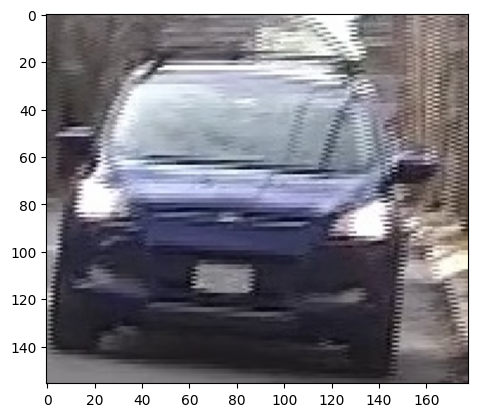

In [17]:
crop = cv2.imread("data_crops/ford_escape_2011_blue_02/frame102.jpg")
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

In [18]:
predict_class(crop)

'ford_escape_2011_blue'